In [14]:
from skimage.feature import match_template
from math import ceil
import numpy as np

In [431]:
from skimage import data, color
lena = color.rgb2gray(data.lena())

In [182]:
%matplotlib inline
from skimage.io import imread, imshow
from skimage.transform import resize
from matplotlib.pyplot import figure, subplot, plot, yticks, xticks, legend

def imshow_downscale(img):
    "matplotlib is slooooow, showing downscaled images is speedier"
    y,x = img.shape
    # downscale factor
    k = ceil(y//512+0.1)
    imshow(resize(img, (y//k, x//k)))

    # real ticks
    if y > x:
        # less ticks if not square image
        y_step = y//6
        x_step = int(y_step*x/y)
    if x < y:
        y_step = y//6
        x_step = int(y_step*y/x)
    else:
        y_step = y//6
        x_step = x//6

    yticks(range(0,y//k,y_step//k), [str(y) for y in range(0,y,y_step)])
    xticks(range(0,x//k,x_step//k), [str(x) for x in range(0,x,x_step)]);

def side_by_side(*images):
    "view images side by side"
    size = len(images)
    figure(figsize=(size*5,5))
    for i,img in enumerate(images):
        subplot(1, size, i+1)
        imshow_downscale(img)

In [432]:
img1 = lena
img2 = np.zeros_like(lena)
img2[:,:100] = img1[:,512-100:]

In [433]:
y,x = img1.shape
yy,xx = img2.shape

# assume that 1000 pixels is enough to correlate
rows = ceil(1001//yy)+1 # 1 or more rows
x_template = img2[:,:rows]

x_match = match_template(img1, x_template)
x_offset = np.argmax(x_match)
x_overlap = x - x_offset

# do y correlation with found x_offset on half of yy
y_quarter = yy//4
y_template = img2[y_quarter:3*y_quarter, :x_overlap]
y_match = match_template(img1[:, x_offset:], y_template)
y_offset = np.argmax(y_match) - y_quarter

(0, 412)

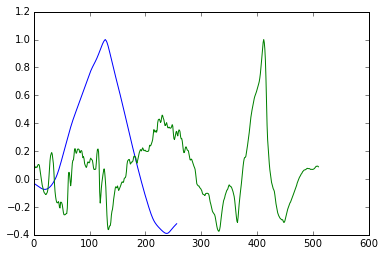

In [434]:
plot(y_match[:,0])
plot(x_match[0,:])
y_offset, x_offset

In [237]:
def stitch(img1, img2, dy, dx):
    y,x = img1.shape
    yy,xx = img2.shape
    
    if dy >= 0:
        y_pos1 = slice(0, y)
        y_pos2 = slice(dy, yy+dy)
    if dy < 0:
        y_pos1 = slice(-dy, y-dy)
        y_pos2 = slice(0, yy)
    if dx >= 0:
        x_pos1 = slice(0, x)
        x_pos2 = slice(dx, xx+dx)
    if dx < 0:
        x_pos1 = slice(-dx, x-dx)
        x_pos2 = slice(0, xx)
    
    Y = max((y_pos1.stop, y_pos2.stop)) - min((y_pos1.start, y_pos2.start))
    X = max((x_pos1.stop, x_pos2.stop)) - min((x_pos1.start, x_pos2.start))
    
    merged = np.zeros((Y,X), dtype=img1.dtype)
    merged[y_pos1,x_pos1] = img1
    merged[y_pos2,x_pos2] = img2
    
    return merged

In [137]:
def correlate_beside(img1, img2):
    """Find offset between img1 and im2. Assumes img2 is 
    to the right of img1 and that they are of same size.
    """
    y,x = img1.shape
    yy,xx = img2.shape

    # assume that 1000 pixels is enough for correlation
    rows = ceil(999//yy)+1 # 1 or more rows
    x_template = img2[:,:rows]

    x_match = match_template(img1, x_template)
    x_offset = np.argmax(x_match)
    x_overlap = x - x_offset

    # do y correlation with found x_offset on half of yy
    y_quarter = yy//4
    y_template = img2[y_quarter:3*y_quarter, :x_overlap]
    y_match = match_template(img1[:, x_offset:], y_template)
    y_offset = np.argmax(y_match) - y_quarter
    
    #err = np.sum( img1[y_offset:yy, x_offset:xx] - img2[] )
    return y_offset, x_offset

In [476]:
def correlate_beside(img1, img2):
    y,x = img1.shape
    half_x = x//2
    yy,xx = img2.shape

    y_quarter = yy//4
    # assume that 2000 pixels is enough for correlation
    rows = ceil(1999//y_quarter)+1 # 1 or more rows

    template = img2[y_quarter:3*y_quarter, :rows]
    match = match_template(img1[:,half_x:], template, pad_input=True)
#    side_by_side(img1[:,x//2:], img2, template, match/match.max())

    max_pos = np.unravel_index(np.argmax(match), (y, half_x))
    return max_pos[0] - img2.shape[0]//2, max_pos[1] - template.shape[1]//2 + half_x
#    return max_pos, img1.shape, img2.shape, template.shape

In [477]:
offset = correlate_beside(img1, img2)
offset

(100, 412)

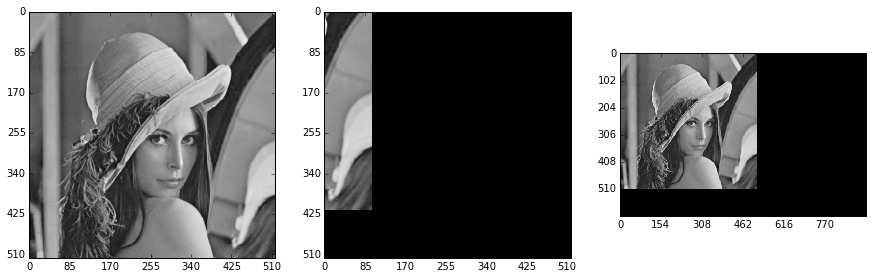

In [478]:
merged = stitch(img1, img2, *offset)
side_by_side(img1, img2, merged)

In [479]:
img1 = imread('highres1.png')
img2 = imread('highres2.png')

%time offset = correlate_beside(img1, img2)
offset

CPU times: user 30.4 s, sys: 12.8 s, total: 43.2 s
Wall time: 48.2 s


(-22, 5219)

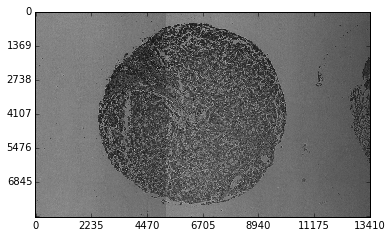

In [480]:
merged = stitch(img1, img2, -22, 5219)
imshow_downscale(merged)

In [422]:
from skimage.feature import register_translation

In [482]:
%%time
#def correlate_beside(img1, img2):
y,x = img1.shape
half_x = x//2
yy,xx = img2.shape

y_quarter = yy//4
# assume that 2000 pixels is enough for correlation
rows = ceil(1999//y_quarter)+1 # 1 or more rows

template = np.zeros_like(img1[:, half_x:])
template[:2*y_quarter, :rows] = img2[y_quarter:3*y_quarter, :rows]
match = register_translation(img1[:, half_x:], template)

#    max_pos = np.unravel_index(np.argmax(match), img1.shape)
#    return max_pos[0] - img2.shape[0]//2, max_pos[1] - template.shape[1]//2

CPU times: user 17.7 s, sys: 6.02 s, total: 23.7 s
Wall time: 26.2 s


In [483]:
match

(array([-2554.,     8.]), 0.99989768375581844, 5.9818878408108698e-16)

# on overview

In [485]:
from leicaexperiment import Experiment
e = Experiment('data/experiment--2015_04_29_12_46_29/')

In [547]:
def find_outliers(data, m=3):
    return abs(data - np.mean(data)) > m * np.std(data)

def cancel_outliers(data):
    outliers = find_outliers(data)
    i = 0
    while np.any(outliers) and i < 20:
        data[outliers] = np.median(data)
        outliers = find_outliers(data)
        i += 1
    # data changed in place, return anyhow
    if i == 20:
        print('warning, max iterations (20) reached')
    return data

In [548]:
rows = e.rows(0,0)
cols = e.columns(0,0)

In [549]:
%%time
translations = []
for row in rows:
    for col in cols:
        p1 = e.image(0,0,col,row)
        p2 = e.image(0,0,col+1,row)
        if not p2:
            continue
        img1 = imread(p1)
        img2 = imread(p2)
        translations.append(correlate_beside(img1, img2) + (row, col))
translations = np.array(translations)

CPU times: user 17.4 s, sys: 5.4 s, total: 22.8 s
Wall time: 23 s


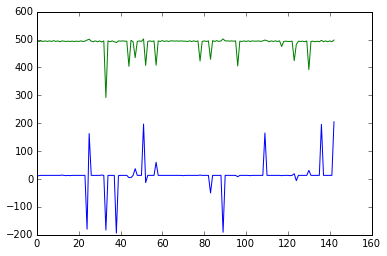

In [550]:
plot(translations)

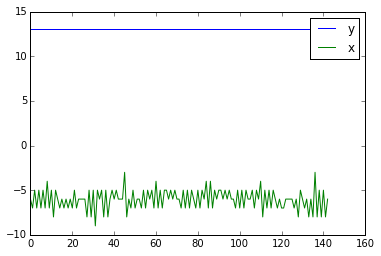

In [551]:
cancel_outliers(translations[:,0])
cancel_outliers(translations[:,1])
plot(translations[:,0])
plot(translations[:,1]-500)
legend('yx');

In [553]:
%matplotlib qt

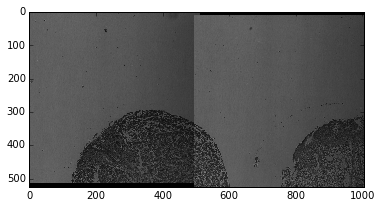

In [554]:
img1 = imread(e.image(0,0,0,0))
img2 = imread(e.image(0,0,1,0))

merged = stitch(img1, img2, translations[:,0].mean(), translations[:,1].mean())
imshow(merged)

In [557]:
from skimage.io import imsave
imsave('merged.png', merged)

In [556]:
merged.dtype

dtype('uint8')